<a href="https://colab.research.google.com/github/HoangHungLN/MachineLearning_Assignment/blob/main/Assignment3/notebooks/Assignment3_CEML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/HoangHungLN/MachineLearning_Assignment.git

fatal: destination path 'MachineLearning_Assignment' already exists and is not an empty directory.


In [8]:
!cd MachineLearning_Assignment && git lfs pull

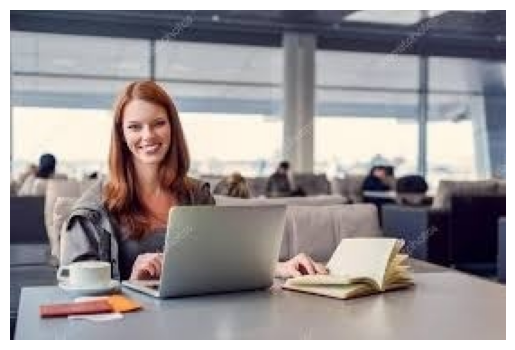

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Đường dẫn đến ảnh
img_path = "MachineLearning_Assignment/Assignment3/data/HumanActionDataset/Image_2324.jpg"

# Mở ảnh
img = Image.open(img_path)

# Hiển thị ảnh
plt.imshow(img)
plt.axis("off")  # tắt trục
plt.show()
